# **<center>Analysis of Indian Product Reviews on Amazon</center>**

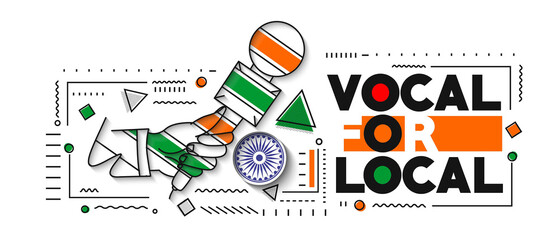




## What is Vocal for Local ? 

In order to support Indian brands, 'Vocal for Local' campaign was started in India. Emphasizing on a self-reliant, or ‘aatmanirbhar’, India, the Indian government has asked that products not just be made in India, but also for the promotion of local brands, manufacturing, and supply chain. The purpose of Vocal for Local is to support as many local/Indian brands as possible.

In this notebook, I will make an attempt to analyse reviews of different Indian products available on Amazon. 

## Table of Contents

* [Understanding the data](#chapter1)
* [Data Cleaning](#section_1_1)
* [Top 5 Names of brands with least number of reviews](#section_1_2)
* [Top 5 Names of brands with most number of reviews](#section_1_2_1)
* [Wordcloud of all the reviews](#section_1_2_2)
* [Distribution of Ratings](#section_1_2_3)
* [Proportion of Sentiments](#chapter2)
* [Positive Sentiment Wordcloud](#section_2_1)
* [Negative Sentiment Wordcloud](#section_2_2)
* [Neutral Sentiment Wordcloud](#section_2_3)

In [ ]:
import pandas as pd 
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
from wordcloud import WordCloud , ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

### Understanding the data <a class="anchor" id="chapter1"></a>

In [ ]:
df = pd.read_csv('../input/indian-products-on-amazon/amazon_vfl_reviews.csv')

df.head()

In [ ]:
df.shape

The dataset comprises of **2782** rows and **5** columns:-

**asin** : Amazon Standard Identification Number - a unique number for every product

**name** : Name of the product

**date** : Date on which review was posted

**rating** : Rating given to the product ( out of 5 )

**review** : Review given to the product

### Data Cleaning <a class="anchor" id="section_1_1"></a>

In [ ]:
df.isnull().sum()

There are **4** null values in the **review** column, we will drop these rows.

In [ ]:
df.dropna(inplace=True)
df = df.reset_index()
df = df.drop(['index'], axis = 1) 
df.shape

In [ ]:
len(df['name'].unique())

We have a total of **122** unique products in our dataset.

In [ ]:
df['name'].sample(n=3)

We can observe a pattern in the product name using which we can extract the brand name i.e the first name

In [ ]:
def get_brand(x):
    return x.split('-')[0]
df['brand'] = df['name'].apply(get_brand)

In [ ]:
df['brand'].unique()

We can see that there is some inconsistency in the brand names. **PATANJALI** and **Patanjali** are the same and same applies to **MYSORE** and **Mysore**. We will remove this incosistency.

In [ ]:
df['brand'] = df['brand'].str.replace('PATANJALI', 'Patanjali')
df['brand'] = df['brand'].str.replace('MYSORE', 'Mysore')

In [ ]:
len(df['brand'].unique())

We have a total of **24** unique Indian brands

### Top 5 Names of brands with least number of reviews <a class="anchor" id="section_1_2"></a>

In [ ]:
df1 = pd.DataFrame(df.groupby('brand')['asin'].count().reset_index())
df1.columns=['brand','count']
sort_df = df1.sort_values(['count'],ascending=True)

fig = px.bar(sort_df.iloc[:5,:],y='brand',x='count',
             orientation='h',color='count')
fig.update_layout(title_text='Top 5 Names of brands with least number of reviews',title_x=0.5,
                  template='plotly_dark')
fig.show()

The least number of reviews are of brands like **Indiana** and **NutriChoice** - **6** and **12** respectively. **Coca-cola**, **Savlon** and **Maggi** have **20** reviews each.

### Top 5 Names of brands with most number of reviews <a class="anchor" id="section_1_2_1"></a>

In [ ]:
brand = sort_df.iloc[-5:,:]['brand'].tolist()
count=sort_df.iloc[-5:,:]['count'].tolist()

fig = go.Figure(data=[go.Table(header=dict(values=['Brand','Number of Reviews'],
                                          fill_color='blue',
                                           height=30),
                 cells=dict(values=[brand,count],
                            height=30))
                     ])
fig.update_layout(title_text='Top 5 Names of brands with most number of reviews',title_x=0.5,
                  template='plotly_dark')
fig.show()

Each of **Himalaya**, **Godrej**, **Cinthol**, **Titan** and **Mamaearth** have the most number of reviews which is **200** reviews. 

### Wordcloud of all the reviews <a class="anchor" id="section_1_2_2"></a>

In [ ]:
stop_words = stopwords.words('english')

corpus = []
for i in range(0,len(df)):
    text = re.sub('[^a-zA-Z]', ' ', df['review'][i])
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = ' '.join(text)
    corpus.append(text)

In [ ]:
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'RdYlGn', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, 
                       background_color = 'black').generate(' '.join(corpus))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.axis('off')
plt.show()

### Distribution of Ratings <a class="anchor" id="section_1_2_3"></a>

In [ ]:
rating_df = pd.DataFrame(df['rating'].value_counts().reset_index())
rating_df.columns=['rating','count']

fig = px.bar(rating_df,x='rating',y='count',
            color_discrete_sequence=['purple'])
fig.update_layout(title_text='Distribution of Ratings',title_x=0.5
                  ,template='plotly_dark')
fig.show()

- A rating of **5** stars has been given to almost **1444** products.  
- About **19.65%** of the products are rated as **1** star.
- The least number of products i.e **122** are given **2** star rating.

### Proportion of Sentiments <a class="anchor" id="chapter2"></a>

Here we will use **TextBlob** library to perform **Sentiment Analysis** on product reviews. TextBlob is a Python library for processing textual data. It provides a consistent API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, and more.

For calculating sentiment, we will calculate **polarity**. It simply means emotions expressed in a sentence.

Polarity of a sentence lies between ( -1 to 1 ) **-1** being **Negative** and **1** being **Positive**. A polarity of **0** means **Neutral** sentiment.

In [ ]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

df['polarity_score'] = df['review'].\
   apply(lambda x : polarity(x))

def sentiment(x):
    if x<0:
        return 'negative'
    elif x==0:
        return 'neutral'
    else:
        return 'positive'
    
df['polarity'] = df['polarity_score'].\
   map(lambda x: sentiment(x))

In [ ]:
fig = go.Figure(data=[go.Pie(labels=df['polarity'].value_counts().index.tolist(),
                             values=df['polarity'].value_counts().tolist(),
                            marker=dict(colors=['#006400','#8B0000','#add8e6']))])

fig.update_layout(title_text='Proportion of Sentiments',title_x=0.5,
                  template='plotly_dark')
fig.show()

- Most of the reviews are **Positive**. 
- About **8.42%** are **Neutral** reviews.
- Out of **2778** reviews, **410** are Negative. 

### Positive Sentiment Wordcloud <a class="anchor" id="section_2_1"></a>

In [ ]:
def get_data(df,senti):
    s_df = df[df['polarity']==senti].reset_index()
    
    s_corpus = []
    for i in range(0,len(s_df)):
        text = re.sub('[^a-zA-Z]', ' ', s_df['review'][i])
        text = text.lower()
        text = text.split()
        text = [word for word in text if not word in stop_words]
        text = ' '.join(text)
        s_corpus.append(text)
    return s_corpus

p_corpus = get_data(df,'positive')
n_corpus = get_data(df,'negative')
nt_corpus = get_data(df,'neutral')

In [ ]:
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'Greens', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, 
                       background_color = 'black').generate(' '.join(p_corpus))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.axis('off')
plt.show()

### Negative Sentiment Wordcloud <a class="anchor" id="section_2_2"></a>

In [ ]:
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'Reds', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, 
                       background_color = 'black').generate(' '.join(n_corpus))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.axis('off')
plt.show()

### Neutral Sentiment Wordcloud <a class="anchor" id="section_2_3"></a>

In [ ]:
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'Blues', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, 
                       background_color = 'black').generate(' '.join(nt_corpus))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.axis('off')
plt.show()

From the above wordclouds, we can observe that:-
- Words like **good**, **better**, **awesome** are used to describe the products highlighting a positive sentiment.
- For describing negative sentiments, words used are **fake**, **waste**. 

## I will add more work in the next versions. Work in Progress...